### LightGBM

강주형_T5008

In [41]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

## 1. Data Load

In [42]:
data_dir = '../data' 
csv_file_path = os.path.join(data_dir, 'train_data.csv')
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')

dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

train_df = pd.read_csv(csv_file_path, dtype=dtype, parse_dates=['Timestamp']) 
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])

In [43]:
### 학습에 Test 데이터 활용
df = pd.concat([train_df, test_df])
df = df[df['answerCode'] != -1]

## 2. Feature Engineering

In [46]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    ### 소요시간
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    df['elapsed'] = diff
    elapsed_median = df[df['elapsed'] < 300]['elapsed'].median()
    def elapsed_preprocessing(x):
        if x >= 300 or x == 0:
            return elapsed_median
        return x
    df['elapsed'] = df['elapsed'].apply(elapsed_preprocessing)


    ### 연속적으로 푼 태그 정보 추가
    df['continuous_tag'] = (df.groupby(['userID', 'KnowledgeTag']).cumcount() + 1).astype(int)
    
    
    ### 문항이 속한 태그 중 사용자가 이전에 푼 문항에서 맞춘 비율
    df['user_tag_cum_acc'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x: x.expanding().mean().shift(1))
    
    ### 주말 여부
    time = df['Timestamp'].dt.day_name()
    def isWeekend_preprocessing(x):
        if x =='Saturday' or x =='Sunday':
            x = 1
        else:
            x = 0
        return x
    df['isWeekend'] = time.apply(isWeekend_preprocessing)
    
    
    df['test_category'] = df['testId'].str[2].astype('int8')
    df["test_category_cum_acc"] = df.groupby(["userID", "test_category"])["answerCode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df["test_category_cum_count"] = df.groupby(["userID", "test_category"]).cumcount()
    df["test_category_cum_acc_rate"] = ( df["test_category_cum_acc"] / df["test_category_cum_count"] ).fillna(0)

    df["test_category_elapsed"] = df.groupby(["userID", "test_category"])["elapsed"].transform(lambda x: x.cumsum()).fillna(0)
    
    ### 
    df['lag_time'] = df.groupby('userID')['Timestamp'].diff().dt.seconds.fillna(0, downcast='int')

    scaler_lag_time = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
    raw_vec_lag_time = df['lag_time'].values.reshape(-1, 1)

    scaler_lag_time.fit(raw_vec_lag_time)

    df['lag_time'] = scaler_lag_time.transform(raw_vec_lag_time).reshape(1, -1)[0]


    ###
    test_timestamp = df.groupby(['userID', 'testId']).agg(test_timestamp=('Timestamp', min))
    test_timestamp.reset_index(inplace=True)
    df = pd.merge(left=df, right=test_timestamp, how='left', on=['userID', 'testId'])


    ###
    test_lag_time = df.groupby('userID')['test_timestamp'].diff().dt.total_seconds() // 3600
    test_lag_time.replace(0, np.NaN, inplace=True) # 0을 결측값으로 변경
    test_lag_time.fillna(method='pad', inplace=True) # 결측값을 앞 방향으로 채우기
    test_lag_time.fillna(0, inplace=True)
    test_lag_time.clip(lower=0, upper=300, inplace=True)
    df['test_lag_time'] = test_lag_time
    scaler_test_lag_time = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
    raw_vec_test_lag_time = df['test_lag_time'].values.reshape(-1, 1)
    scaler_test_lag_time.fit(raw_vec_test_lag_time)
    df['test_lag_time'] = scaler_test_lag_time.transform(raw_vec_test_lag_time).reshape(1, -1)[0]

    
    return df

In [47]:
def feature_engineering_train(df):
    global correct_t, correct_k, question_accuracy
    
    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    ### 사용자가 이전에 푼 문항과 동일한 지식 태그를 포함한 문항일 경우 정답률이 높아지는 경향이 있는 지 여부
    # 문항별 정답률 계산
    question_accuracy = df.groupby('assessmentItemID')['answerCode'].mean()
    
    # 이전에 푼 문항과 동일한 태그를 가진 문항일 경우 1, 그렇지 않을 경우 0으로 구성된 새로운 변수 생성
    df['similar_tag_answered'] = df.groupby('userID')['KnowledgeTag'].apply(lambda x: x.eq(x.shift()).astype(int)).reset_index(drop=True)
    # 이전에 푼 문항과 동일한 태그를 가진 문항일 경우 그 문항의 정답률 계산
    df['similar_tag_accuracy'] = df['assessmentItemID'].map(question_accuracy) * df['similar_tag_answered']
    # 만약 이전에 푼 문항과 동일한 태그를 가진 문항이 없을 경우에는 정답률이 0이 되도록 함
    df['similar_tag_accuracy'].fillna(0, inplace=True)
    df = df.drop(['similar_tag_answered'], axis=1)
    
    
    
    
    return df

In [48]:
def feature_engineering_test(df):
    global correct_t, correct_k, question_accuracy
    
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    # 이전에 푼 문항과 동일한 태그를 가진 문항일 경우 1, 그렇지 않을 경우 0으로 구성된 새로운 변수 생성
    df['similar_tag_answered'] = df.groupby('userID')['KnowledgeTag'].apply(lambda x: x.eq(x.shift()).astype(int)).reset_index(drop=True)
    # 이전에 푼 문항과 동일한 태그를 가진 문항일 경우 그 문항의 정답률 계산
    df['similar_tag_accuracy'] = df['assessmentItemID'].map(question_accuracy) * df['similar_tag_answered']
    # 만약 이전에 푼 문항과 동일한 태그를 가진 문항이 없을 경우에는 정답률이 0이 되도록 함
    df['similar_tag_accuracy'].fillna(0, inplace=True)
    df = df.drop(['similar_tag_answered'], axis=1)
    
    return df

In [49]:
df = feature_engineering(df)
df = feature_engineering_train(df)

In [50]:
# tag_difficult, tag_answer_rate, id_difficult, id_answer_rate Feature 활용

df_id = pd.read_csv('id.csv')
df_tag = pd.read_csv('tag.csv')

In [51]:
df = pd.merge(pd.merge(df, df_id, on='assessmentItemID', how='left'), df_tag, on='KnowledgeTag', how='left')

## 3. Data Split

In [53]:
# Data Split by UserID
random.seed(4948)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [61]:
# Train, Test Split
train, test = custom_train_test_split(df)

# Features Setting
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum', 'continuous_tag', 'user_tag_cum_acc', 'similar_tag_accuracy', 'id_answer_rate', 'id_difficult', 'tag_difficult', 'test_category_cum_acc_rate', 'test_category_elapsed', 'elapsed']

# Feature, Class Split
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

## 4. Train and Inference

In [ ]:
# Base Score Check

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

lgb_train = LGBMClassifier().fit(train[FEATS], y_train)
lgb_test = LGBMClassifier().fit(test[FEATS], y_test)

model = LGBMClassifier(
objective='binary',
num_boost_round=500,
early_stopping_rounds=100,
boost_from_average=False,
)

model.fit(
train[FEATS], y_train,
eval_set=[(train[FEATS], y_train), (test[FEATS], y_test)],
eval_metric='ruc_auc_score',
verbose=100
)

preds = model.predict_proba(test[FEATS])[:, 1]
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

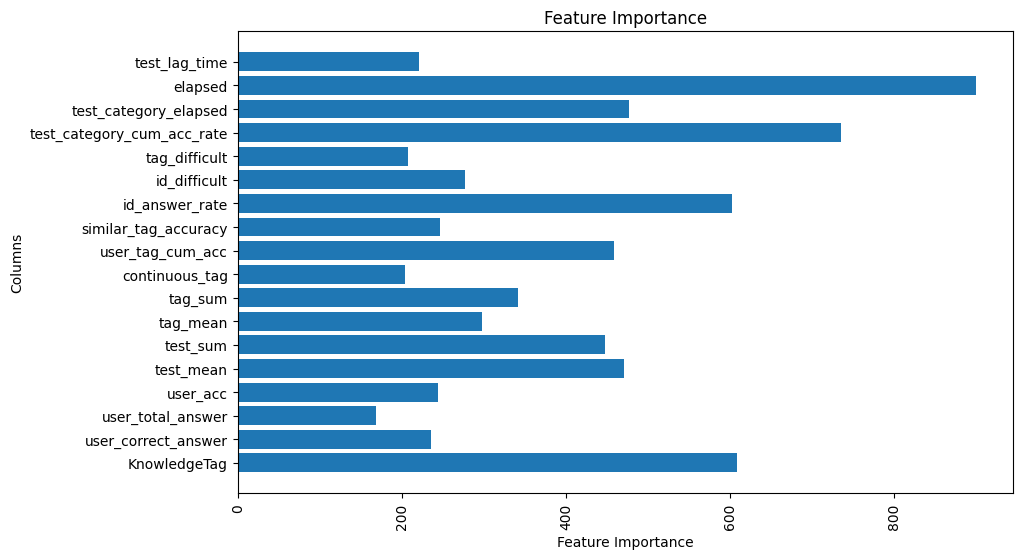

In [64]:
# Feature Importances

feature = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(FEATS, feature)
plt.xticks(rotation=90)
plt.xlabel('Feature Importance')
plt.ylabel('Columns')
plt.title('Feature Importance')
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb

# Optuna Libraries
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# train_test_split
from sklearn.model_selection import train_test_split

# Random sampler
sampler = TPESampler(seed=10)

# Define function
def objective(trial):

    params = {
        'boost_from_average':'False',
        'objective': 'binary',
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    # Generate model
    model = LGBMClassifier(**params)
    model.fit(
        train[FEATS], y_train,
        eval_set=[(test[FEATS], y_test)],
        eval_metric='auc',
        verbose=100,
        callbacks = [lgb.early_stopping(stopping_rounds = 20)]
        )
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    AUC = roc_auc_score(y_test, model.predict_proba(test[FEATS])[:, 1])
    return AUC

optuna_model = optuna.create_study(direction='maximize', study_name='LGBMClassifier', sampler=sampler)
optuna_model.optimize(objective, n_trials=100)

In [ ]:
model_trial = optuna_model.best_trial
model_trial_params = model_trial.params
print('Best Trial: score {},\nparams {}'.format(model_trial.value, model_trial_params))

In [ ]:
# Model fit

model = LGBMClassifier(**model_trial_params, verbose=0)
model.fit(df[FEATS], df['answerCode'])

## 5. Test Inference

In [69]:
# Load Test
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])

# Feature engineering
test_df = feature_engineering(test_df)
test_df = feature_engineering_test(test_df)
test_df = pd.merge(pd.merge(test_df, df_id, on='assessmentItemID', how='left'), df_tag, on='KnowledgeTag', how='left')

# Leave Last Interaction Only
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# Drop answerCode
test_df = test_df.drop(['answerCode'], axis=1)

# Make prediction
total_preds = model.predict_proba(test_df[FEATS])[:, 1]



In [ ]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))